In [15]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pdb
import copy

%matplotlib inline

import tree_structure
import fitting_tools
import objective_builders

# Examining Single-Feature Splitting

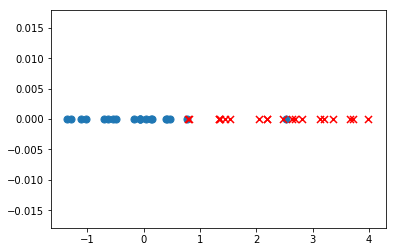

In [10]:
# generate two-gaussian data samples
# class one
n1 = 20
n2 = 20
X1 = 1.1*np.random.randn(n1)
X2 = np.random.randn(n2) + 2

plt.scatter(X1, np.zeros(n1), marker='o', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)

## Splitting with C4.5

In [260]:
# going through the mid-points one-by-one

# number of classes
c = len(np.unique(labels))

# sorting the data
inds = np.argsort(X)
scores = np.zeros(n1+n2-1)
thetas = np.zeros(n1+n2-1)
eps = 1e-6
for i in range(n1+n2-1):
    thetas[i] = (X[inds[i]] + X[inds[i+1]]) / 2.
    prop = np.zeros((2,c))
    
    # proportions of the classes
    for j in range(c):
        # left side
        prop[0,j] = np.sum(labels[X <= thetas[i]]==j+1) / float(i+1)
        # right side
        prop[1,j] = np.sum(labels[X > thetas[i]]==j+1) / float(n1+n2-(i+1))
        
    # entropy
    entropies = -np.sum((prop+eps) * np.log(prop+eps), axis=1)
    scores[i] = ((i+1)*entropies[0] + (n1+n2-i-1)*entropies[1]) / (n1+n2)

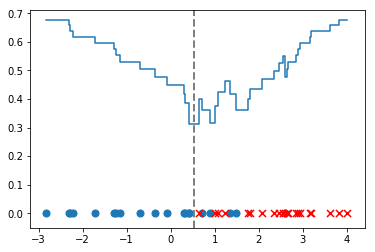

In [292]:
# the result:
best_theta = thetas[np.argmin(scores)]

plt.scatter(X1, np.zeros(n1), marker='o', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)

plt.step(X[inds], np.append(scores[0],scores))
plt.axvline(best_theta, linewidth=2, color='gray', linestyle = '--')

In [290]:
np.append(scores[0],scores)

array([ 0.67549768,  0.67549768,  0.65717348,  0.63811766,  0.61826616,
        0.59754567,  0.57587167,  0.55314583,  0.52925271,  0.50405522,
        0.47738846,  0.449051  ,  0.41879227,  0.3862934 ,  0.351137  ,
        0.31275622,  0.40056092,  0.36075175,  0.31562104,  0.37514678,
        0.42270915,  0.46280622,  0.41775116,  0.36075175,  0.40056092,
        0.43627382,  0.46868149,  0.49832953,  0.52560974,  0.55080938,
        0.47738846,  0.50405522,  0.52925271,  0.55314583,  0.57587167,
        0.59754567,  0.61826616,  0.63811766,  0.65717348,  0.67549768])

## Splitting with Densities

First, let's do a density estimation for each class. Here, we do kernel density estimation (KDE):
$$p(x|y=j) = \frac{1}{n_j}\sum_{y_i=j} k_G(x,x_i)=\frac{1}{n_j\sqrt{2\pi}\sigma}\sum_{y_i=j}e^{-(x-x_i)^2/2\sigma} $$

In [167]:
sigma = .5

# defining KDE function with Gaussian kernel
def class_kernel_1D(dat, x, sigma):
    density_val = 0
    n = dat.shape
    for i in range(len(dat)):
        density_val += np.exp(-(dat[i]-x)**2/(2*sigma)) / (sigma*np.sqrt(2*np.pi))
    return density_val

kernel_c1 = lambda x: class_kernel_1D(X[labels==1], x, sigma)
kernel_c2 = lambda x: class_kernel_1D(X[labels==2], x, sigma)


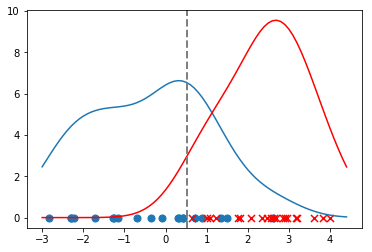

In [171]:
plt.scatter(X1, np.zeros(n1), marker='o', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)

eval_points = np.arange(-3,4.5,.1)
plt.plot(eval_points, kernel_c1(eval_points))
plt.plot(eval_points, kernel_c2(eval_points), color='r')

plt.axvline(best_theta, linewidth=2, color='gray', linestyle = '--')

Now, let's form the density-based objective:
$$ -\sum_{j=1}^2 \mathbb{P}(y=j|x\leq \theta) \log\mathbb{P}(y=j|x\leq \theta)$$

where from Bayes rule
$$ \mathbb{P}(y=j|x\leq \theta) = \frac{\mathbb{P}(x\leq\theta|y=j)\cdot\mathbb{P}(y=j)}{\mathbb{P}(x\leq\theta)}.$$

After some simplifications, we get the following objective:
$$ J(\theta) = -\mathbb{E}_y[KL(q(\theta, y), q'(\theta)],$$
where "KL" is the KL-divergence measure, $q_1$ and $q_2$ are two two-element PMFs whose mass probabilities depend on $\theta$:
$$q(\theta,y) = [\mathbb{P}(x\leq\theta|y), \mathbb{P}(x>\theta|y)]$$
$$q'(\theta) = [\mathbb{P}(x\leq\theta), \mathbb{P}(x>\theta)]$$

The objective $J(\theta)$ can also be written as
$$ J(\theta) = \sum_{y=1}^c\pi_j\left[q_1(\theta,j)\log\frac{q'_1(\theta)}{q_1(\theta,j)} + q_2(\theta,j)\log\frac{q'_2(\theta)}{q_2(\theta,j)} \right]$$
where, assuming that we are using Gaussian kernels, we get the following for the CDFs:
$$\pi_j = \frac{n_j}{n},$$
$$ q_1(\theta,y=j) = \mathbb{P}(x\leq\theta|y=j)=\int_{-\infty}^\theta p(x|y=j)dx = \frac{1}{n_j}\sum_{y_i=j}\Phi\left(\frac{\theta-x_i}{\sigma}\right).$$
and
$$ q'_1(\theta) = \mathbb{P}(x\leq\theta)=\int_{-\infty}^\theta p(x)dx = \frac{1}{n}\sum_{i=1}^n\Phi\left(\frac{\theta-x_i}{\sigma}\right).$$

In [247]:
# first computing all the variables present in the equations above

# we can generate q_1 and q'_1 values using the following function
q = lambda theta,dat,sigma: np.sum(norm.cdf((theta - dat)/sigma)) / len(dat)

# the objective function J:
def objective_func(X, labels, sigma, q, theta):
    J = 0
    for j in range(c):
        pi = np.sum(labels==j+1) / float(len(X))
        # different terms
        q_1 = q(theta, X[labels==j+1], sigma)
        qpr_1 = q(theta, X, sigma)
        # adding the corresponding term
        J += pi*(q_1*np.log(qpr_1/q_1) + (1-q_1)*np.log((1-qpr_1) / (1-q_1)))
    
    return J

eval_points = np.arange(-3,4.5,.1)
Js = np.zeros(len(eval_points))
for i in range(len(eval_points)):
    theta = eval_points[i]
    Js[i] = objective_func(X, labels, sigma, q, theta)

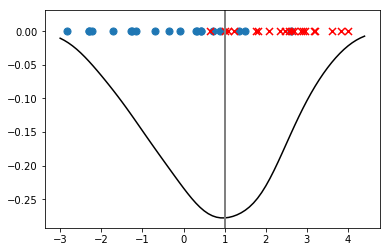

In [251]:
plt.scatter(X1, np.zeros(n1), marker='o', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)
plt.plot(eval_points, Js, color='k')

plt.axvline(eval_points[np.argmin(Js)], linewidth=2, color='gray', linestyle = '-')

Comparing the specified threshold with the empirical one:

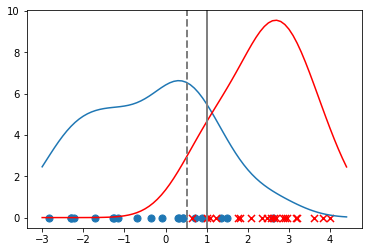

In [250]:
plt.scatter(X1, np.zeros(n1), marker='o', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)

eval_points = np.arange(-3,4.5,.1)
plt.plot(eval_points, kernel_c1(eval_points))
plt.plot(eval_points, kernel_c2(eval_points), color='r')

plt.axvline(best_theta, linewidth=2, color='gray', linestyle = '--')
plt.axvline(eval_points[np.argmin(Js)], linewidth=2, color='gray', linestyle = '-')

# Bisection Method for Finding the Minimizer

Above, we exhaustively searched for the minimizer of the impurity measure. Below we try to design a more principled way of locating the minimum of impurity measure using a bisectioning method. For such method, we need to start from an inerval $[a,b]$ which we assume contains a local minimum $\hat{\theta}$. In our application, we can set this interval to be the range that the variable on focus (the feature we are trying to threshold) changes. This is because, we always need to make sure that each of the child nodes get at least one sample. If we set $\theta$ to be too large or too small, then one of the nodes will lose all the samples and that is not desirable.

In [655]:
# define the objective as a stand-alone function which can be evaluated at any given theta
J_theta = lambda theta: objective_func(X, labels, sigma, q, theta)

# the initial bracket
a = X.min()
b = X.max()

def bisection_min(J_theta, bracket):
    
    # end-points
    a,b = bracket
    J_a, J_b = (J_theta(a), J_theta(b))
    
    # central mid-points
    x_m = (a+b) / 2.
    J_m = J_theta(x_m)    
    
    tol = 1e-6
    
    # repeat bisectioning until the length of the bracket is small enough
    while(np.abs(a-b) > tol):

        # left and right mid-points
        x_l = (a + x_m) / 2.
        x_r = (b + x_m) / 2.
        J_r, J_l = (J_theta(x_r), J_theta(x_l))
        
        J_min = np.min([J_a, J_b, J_m, J_r, J_l])
        
        # updating
        if (J_min == J_a) | (J_min == J_l):
            b, J_b = (x_m, J_m)            
            x_m, J_m = (x_l, J_l)
        elif J_min == J_m:
            a,b = (x_l, x_r)
            J_a, J_b = (J_l, J_r)
        elif (J_min == J_b) | (J_min == J_r):
            a, J_a = (x_m, J_m)            
            x_m, J_m = (x_r, J_r)
        
    return x_m, J_m

In [373]:
bisection_min(J_theta, (a,b)), Js.min()

((0.95758309256991891, -0.27791269658769147), -0.27783387789726777)

# Constructing a General Tree

So far we have the necessary tools for selecting the splitting threshold for any given variable. In this section, we try to get a set of multivariate data samples, and starting from the root, at each node of the tree, we go through all the variables and compute the best threshold. After going through all the variables, we select the one with the smallest minimized objective and its correspondin threshold.

Before that, we write a general functions for computing the class-conditional and marginal CDFs:

In [345]:
sigma = .5

# assuming that dat is 1-dimensional
marginal_CDF = lambda theta,dat,sigma: np.sum(norm.cdf((theta - dat)/sigma)) / len(dat)
class_CDF = lambda theta,dat,labels,y,sigma: marginal_CDF(theta, dat[labels==y], sigma)

## Class of Node and Trees:

In [24]:
reload(fitting_tools)
reload(tree_structure)
reload(objective_builders)
T = tree_structure.Tree(X, labels)
T.fit_full_tree()
#T.leaves

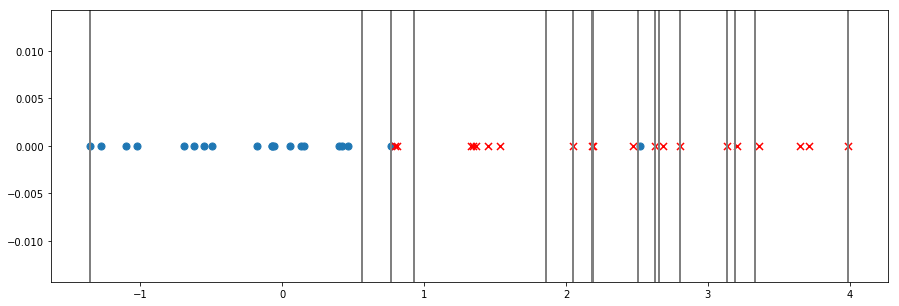

In [25]:
from matplotlib.backends.backend_pdf import PdfPages

fig = plt.figure(figsize=(15,5))

plt.scatter(X1, np.zeros(n1), marker='o', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)

eval_points = np.arange(-3,4.5,.1)
#plt.plot(eval_points, kernel_c1(eval_points))
#plt.plot(eval_points, kernel_c2(eval_points), color='r')

plt.axvline(T.leaves[0].rules['0'][0], linewidth=2, color='gray', linestyle = '-')
plt.axvline(T.leaves[-1].rules['0'][1], linewidth=2, color='gray', linestyle = '-')
with PdfPages('foo.pdf') as pdf:
    for i in range(len(T.leaves)):
        plt.axvline(T.leaves[i].rules['0'][1], linewidth=2, color='gray', linestyle = '-')
        #pdf.savefig(str(i)+".pdf", bbox_inches='tight');
        pdf.savefig(fig)
    

In [732]:
T.leaves[-1].rules

{'0': (2.6165260720903385, 2.6741213165238973)}

In [714]:
def split_features(leaf):
    """
    Computing the best splits of each feature by minimizing the 
    given objectives within the node rule's limits. 
    
    The output would be the best split of each feature and the resulting
    optimization value (scores for the split)
    """
    
    # dimensionality of data
    d = 1 if leaf.dat.ndim==1 else leaf.dat.shape[0]
    
    scores = np.zeros(d)
    thetas = np.zeros(d)
    
    # objective builder
    objectives = KDE_1D_obj_builder(leaf.dat, leaf.labels, normal_CDF)
    
    # do the 1D optimization (inside the intervals permitted by the rules)
    for i in range(d):
        X = leaf.dat[i,:] if d>1 else leaf.dat
        bracket = (max(leaf.rules[str(i)][0], X.min()),
                   min(leaf.rules[str(i)][1], X.max()))
        thetas[i], scores[i] = bisection_min(objectives[i], bracket)
        
    return thetas, scores

def update_rules(new_split, selected_feature, leaf):
    """
    Updating the set of rules of a given leaf node to create
    its left and right children. 
    
    The left child rule will take in the left side of the split, 
    and the right child will take the right side.
    
    NOTE: in case of the right interval (x: theta< x <=b), however, our filter_data
    function always considers '<=' for all types of intervals (which is valid for
    intervals in for the form [a=X.min(), b=X.max()]. But, when a new split theta
    is inroduced we have to consider (a=theta, b=X.max()]. In order to avoid writing
    a new function, we add a very small number to theta, thus [a=theta+epsilon, b=X.max()], 
    which is an approximation for (a=theta, b] for small epsilon values.
    """
    
    eps = 1e-8
    
    # create two copies of the leaf's rules
    left_rules = leaf.rules.copy()
    right_rules = leaf.rules.copy()
    
    # here are the end-points
    (a,b) = leaf.rules[str(selected_feature)]
    
    # rules for left and right children
    if a<new_split<b:
        left_rules[str(selected_feature)] = (a, new_split)
        right_rules[str(selected_feature)] = (new_split+eps, b)
    else:
        raise ValueError('Value of the new split cannot be outside or on the' +
                         'end-points of the current rules.')
        
    return left_rules, right_rules

def filter_data(dat, labels, rules, selected_feature=None):
    """
    Filering the data according to a given set of rules
    """
    if dat.ndim==1:
        (a,b) = rules['0']
        inds_to_del = np.where(np.logical_or(dat<a, b<dat))
        # filtering data and labels
        dat = np.delete(dat, inds_to_del)
        labels = np.delete(labels, inds_to_del)
        
    elif dat.ndim==2:
        # if a feature is given, then only use that for filtering
        if selected_feature:
            (a,b) = rules[str(selected_feature)]
            X = dat[selected_feature,:]
            inds_to_del = np.where(np.logical_or(X<a, b<X))
            # filtering data and labels
            dat = np.delete(dat, inds_to_del, 1)
            labels = np.delete(labels, inds_to_del)
        # if not, look at all the feature one-by-one
        else:
            for i in range(dat.shape[0]):
                (a,b) = rules[str(i)]
                X = dat[i,:]
                inds_to_del = np.where(np.logical_or(X<a, b<X))
                # filtering data and labels
                dat = np.delete(dat, inds_to_del, 1)
                labels = np.delete(labels, inds_to_del)
    
    return dat, labels

## Building the objectives:

The ultimate objective $J(\theta)$ depends only on the marginal and class-conditional CDFs, that is $\mathbb{P}(x\leq\theta)$ and $\mathbb{P}(x\leq\theta|y=j)$ (assuming that $x$ is the particular feature component on focus). When using KDE, these CDFs, in turn, depend on the kernel CDF, defined by
$$F_\Lambda(\theta;x_i) = \int_{\infty}^\theta k(x,x_i),$$

where $x_i$ is a fixed point where the kernel is centered on, and $\Lambda$ are the kernel's parameters (e.g., the bandwidth). Recall, $p(x)=\frac{1}{n}\sum_{i=1}^nk(x,x_i)$ and $p(x|y=j)=\frac{1}{n_j}\sum_{y_i=j}k(x,x_i)$. Then,

$$p(x\leq\theta) = \int_{-\infty}^\theta p(x)dx = \frac{1}{n}\sum_{i=1}^n\int_{-\infty}^\theta k(x,x_i)dx = \frac{1}{n}\sum_{i=1}^n F_{\Lambda}(\theta;x_i).$$

Similar equation can be written for the class-conditional case.

In [716]:
def KDE_1D_obj_builder(dat, labels, kernel_CDF, class_priors=None):
    """
    Constructing the objective function evaluator for an isotropic KDE. 
    
    We need training data samples as well as kernel CDF for computing the objective
    function. The, kernel CDF is a single callable function with a set of parameters. Each dimension
    (feature component) possibly has a different set of parameters. The argument |sigma| is a list of
    parameter sets corresponding to all the dimensions (hence, its length should be equal to the
    number of features in |dat|). Each time, |kernel_CDF| has to be called using a particular set of
    parameters, and a specific data point.
    
    CAUTIOUN 1: |kernel_CDF| should have three arguments only; 
        
        * the first one is the set of parameters:math:`\\Lambda`, 
        * the second one is the sample point on which the kernel is centered, :math:`x_i`, 
        * the last is the value at which the CDF is to be evaluated :math`\\theta`. 
    
    CAUTIOUN 2: |kernel_CDF| should be able to evaluate CDF of the kernel at several data samples in 
    a single call.
    """
    
     
    if dat.ndim==1:
        d = 1
        n = len(dat)
    else:
        d, n = dat.shape
    
    # first of all, we need the priors:
    if not(class_priors):
        symbols = np.unique(labels)
        c = len(symbols)
        class_priors = np.zeros(c)
        for i in range(c):
            class_priors[i] = np.sum(labels==symbols[i]) / float(n)
   
    pies = class_priors
    
    # list of objectives for each dimension
    objectives = [0]*d     # (list initialization)
    
    for i in range(d):
        
        X = dat[i,:] if d>1 else dat
        uncond_sigma = .5
        cond_sigma = .5
        
        # constructing CDF of the non-conditional KDE
        marginal_CDF = lambda theta: kernel_CDF(sigma, X, theta)
        
        # constructing CDF of class-conditional KDE
        class_marginals = [0]*c   # (list initialization)
        for j in range(c):
            class_marginals[j] = lambda theta: kernel_CDF(cond_sigma, X[labels==symbols[j]], theta)
            
        # constructing the overall objective of this i-th feature:
        J_i = lambda theta: np.sum(pies*np.array([f(theta)*np.log(marginal_CDF(theta)/f(theta)) + 
                                                  (1-f(theta))*np.log((1-marginal_CDF(theta))/(1-f(theta))) 
                                                  for f in class_marginals]))
        objectives[i] = J_i
        
    return objectives

def normal_CDF(sigma, dat, theta):
    """
    CDF of a scalar KDE based on Gaussian kernels. 
    
    |sigma| is a positive scalar denoting the variance of the Gaussian kernel.
    """
    return np.sum(norm.cdf((theta - dat)/sigma)) / len(dat)
    

# Testing the Functions

In [606]:
sigmas = [.5]
Js = KDE_1D_obj_builder(X, labels, sigmas, normal_CDF)

T = Tree(X, labels, Js)

#T.fit_full_tree()
T.check_full_stopped()

False